# Generate atmospheric parameters



Generate atmospheric parameters to be used by atmospheric parameters.
The control is done via the config/default.ini file

- Author : Sylvie Dagoret-Campagne
- Last verification : December 13th 2021


In [1]:
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as plt3d
import numpy as np
import os
import matplotlib as mpl
import pandas as pd
import itertools

from astropy import units as u
from astropy.coordinates import Angle

import time
from datetime import datetime,date
import dateutil.parser
import pytz

import argparse

import logging
import coloredlogs
import configparser


In [2]:
from astropy.io import fits

In [3]:
from scipy.stats import rayleigh,beta,gamma,uniform

In [4]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10,6),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [5]:
def SimulateValues(n,distrib_name,a,b,loc,scale):
    """
    """
    if distrib_name == 'rayleigh':
        simdata=rayleigh.rvs(loc, scale=scale,size=n)
    elif distrib_name == 'beta':
        simdata=beta.rvs(a=a,b=b,loc=loc, scale=scale,size=n)
    elif distrib_name == 'gamma':
        simdata=gamma.rvs(a=a,loc=loc, scale=scale,size=n)
    else:
        simdata=uniform.rvs(loc=loc,scale=scale,size=n)
        
    return simdata
    

In [6]:
# date
today = date.today()
string_date = today.strftime("%Y-%m-%d")


# time
now = datetime.now()
current_time = now.strftime("%H:%M:%S")

tim = time.localtime()
current_time = time.strftime("%H:%M:%S", tim)



#timezones
tz_LA = pytz.timezone('America/Los_Angeles')
datetime_LA = datetime.now(tz_LA)
print("LA time:", datetime_LA.strftime("%H:%M:%S"))


tz_NY = pytz.timezone('America/New_York')
datetime_NY = datetime.now(tz_NY)
print("NY time:", datetime_NY.strftime("%H:%M:%S"))

tz_London = pytz.timezone('Europe/London')
datetime_London = datetime.now(tz_London)
print("London time:", datetime_London.strftime("%H:%M:%S"))

tz_Paris = pytz.timezone('Europe/Paris')
datetime_Paris = datetime.now(tz_Paris)
print("Paris time:", datetime_Paris.strftime("%H:%M:%S"))



LA time: 07:01:20
NY time: 10:01:20
London time: 15:01:20
Paris time: 16:01:20


In [7]:
# start with logs
#-----------------
logging.basicConfig()
logging.root.setLevel(logging.NOTSET)

handle = __name__

logger = logging.getLogger(handle)
# logging.getLogger().setLevel(logging.INFO)
logger.setLevel(logging.DEBUG)

# If you don't want to see log messages from libraries, you can pass a
# specific logger object to the install() function. In this case only log
# messages originating from that logger will show up on the terminal.
coloredlogs.install(level='DEBUG', logger=logger)
coloredlogs.install(fmt='%(asctime)s,%(msecs)03d %(hostname)s %(name)s[%(process)d] %(levelname)s %(message)s')

In [8]:
# arguments
#----------


parser = argparse.ArgumentParser()
parser.add_argument("--config",action="store", dest="configfile",help=f" run generate -config configfilename, with by ex configfilename = default.ini")
#results_args = parser.parse_args()

results_args=""
   

In [9]:
msg = f"Start {parser.prog} at date : {string_date} and time :{current_time} and with arguments:{results_args}"
logger.info(msg)

2021-12-13 16:01:20,112 imacdagoret.lal.in2p3.fr __main__[38110] INFO Start ipykernel_launcher.py at date : 2021-12-13 and time :16:01:20 and with arguments:


In [10]:
# config file
# --------------
configfile = "config/default.ini"

#config_filename = results_args.configfile
config_filename = configfile
msg = f"Configuration file : {config_filename}"
logger.info(msg)

2021-12-13 16:01:20,120 imacdagoret.lal.in2p3.fr __main__[38110] INFO Configuration file : config/default.ini


In [11]:
# 1) CONFIGURATION
#------------------
logger.info('1) Configuration')

config = configparser.ConfigParser()

if os.path.exists(config_filename):
    config.read(config_filename)
else:
    msg = f"config file {config_filename} does not exist !"
    logger.error(msg)

config_section = config.sections()

2021-12-13 16:01:20,126 imacdagoret.lal.in2p3.fr __main__[38110] INFO 1) Configuration


In [12]:
if len(config_section) == 0:
    msg = f"empty config file {config_filename} !"
    logger.error(msg)    

In [13]:
if 'GENERAL' in config_section:

    FLAG_DEBUG = bool(config['GENERAL']['FLAG_DEBUG'])
    FLAG_VERBOSE = bool(config['GENERAL']['FLAG_VERBOSE'])
    FLAG_PLOT = bool(config['GENERAL']['FLAG_PLOT'])
    FLAG_PRINT = bool(config['GENERAL']['FLAG_PRINT'])
    output_file = config['GENERAL']['outputfile']
    output_dir  =  config['GENERAL']['outputdir']
    NSIM = int(config['GENERAL']['NSIM'])
else:
    msg = f"empty section GENERAL in config file {config_filename} !"
    logger.error(msg)

In [14]:
if not os.path.exists(output_dir):
        os.makedirs(output_dir)

In [15]:
if 'AEROSOL' in config_section:
    distrib_name = config['AEROSOL']['distrib']
    a=float(config['AEROSOL']['a'])
    b=float(config['AEROSOL']['b'])
    loc=float(config['AEROSOL']['loc'])
    scale=float(config['AEROSOL']['scale'])

In [16]:
simdata=SimulateValues(NSIM,distrib_name,a,b,loc,scale)
VAOD = simdata

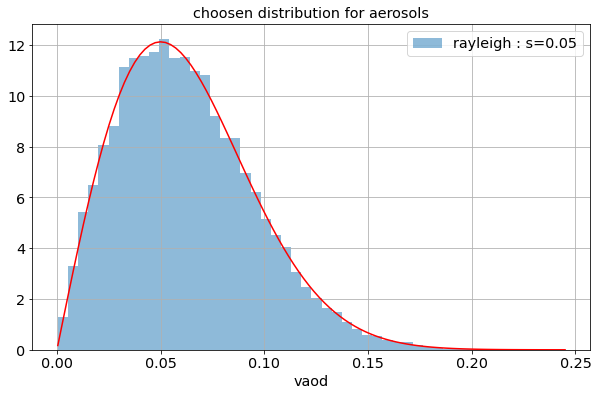

In [17]:
if FLAG_PLOT:
    x=np.linspace(simdata.min(),simdata.max(),100)
    if distrib_name=='rayleigh':
        rv=rayleigh(loc=loc, scale=scale)
    
    fig=plt.figure()
    ax=fig.add_subplot(111)
    label="rayleigh : s={:2.2f}".format(scale)
    ax.hist(simdata,bins=50,density=True, histtype='stepfilled', alpha=0.5,label=label);
    ax.plot(x,rv.pdf(x),"r-")
    ax.grid()
    ax.legend()
    ax.set_xlabel("vaod")
    ax.set_title("choosen distribution for aerosols")

In [18]:
if 'OZONE' in config_section:
    distrib_name = config['OZONE']['distrib']
    a=float(config['OZONE']['a'])
    b=float(config['OZONE']['b'])
    loc=float(config['OZONE']['loc'])
    scale=float(config['OZONE']['scale'])

In [19]:
simdata=SimulateValues(NSIM,distrib_name,a,b,loc,scale)
O3 = simdata

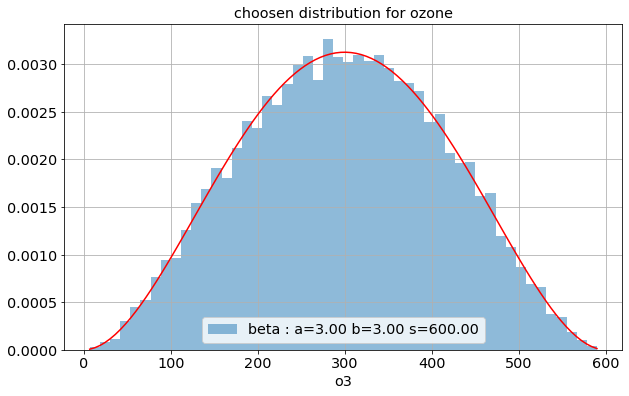

In [20]:
if FLAG_PLOT:
    x=np.linspace(simdata.min(),simdata.max(),100)
    if distrib_name=='beta':
        rv=beta(a=a,b=b,loc=loc, scale=scale)
    
    fig=plt.figure()
    ax=fig.add_subplot(111)
    labelb="beta : a={:2.2f} b={:2.2f} s={:2.2f}".format(a,b,scale)
    ax.hist(simdata,bins=50,density=True, histtype='stepfilled', alpha=0.5,label=labelb);
    ax.plot(x,rv.pdf(x),"r-")
    ax.grid()
    ax.legend()
    ax.set_xlabel("o3")
    ax.set_title("choosen distribution for ozone")

In [21]:
if 'PWV' in config_section:
    distrib_name = config['PWV']['distrib']
    a=float(config['PWV']['a'])
    b=float(config['PWV']['b'])
    loc=float(config['PWV']['loc'])
    scale=float(config['PWV']['scale'])

In [22]:
simdata=SimulateValues(NSIM,distrib_name,a,b,loc,scale)
PWV = simdata

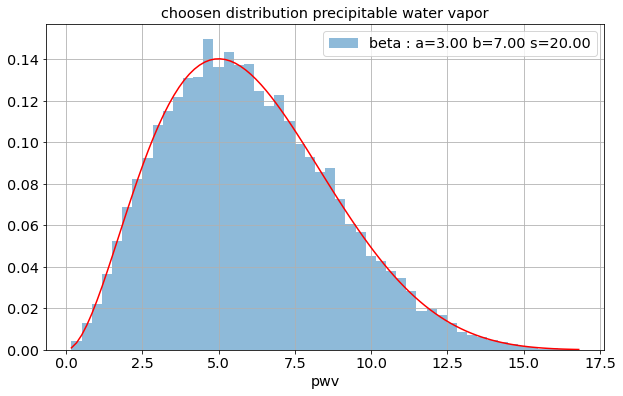

In [23]:
if FLAG_PLOT:
    x=np.linspace(simdata.min(),simdata.max(),100)
    if distrib_name=='beta':
        rv=beta(a=a,b=b,loc=loc, scale=scale)
    
    fig=plt.figure()
    ax=fig.add_subplot(111)
    label="beta : a={:2.2f} b={:2.2f} s={:2.2f}".format(a,b,scale)
    ax.hist(simdata,bins=50,density=True, histtype='stepfilled', alpha=0.5,label=label);
    ax.plot(x,rv.pdf(x),"r-")
    ax.grid()
    ax.legend()
    ax.set_xlabel("pwv")
    ax.set_title("choosen distribution precipitable water vapor")

In [24]:
if 'CLOUD' in config_section:
    distrib_name = config['CLOUD']['distrib']
    a=float(config['CLOUD']['a'])
    b=float(config['CLOUD']['b'])
    loc=float(config['CLOUD']['loc'])
    scale=float(config['CLOUD']['scale'])

In [25]:
simdata=SimulateValues(NSIM,distrib_name,a,b,loc,scale)
CLD = simdata

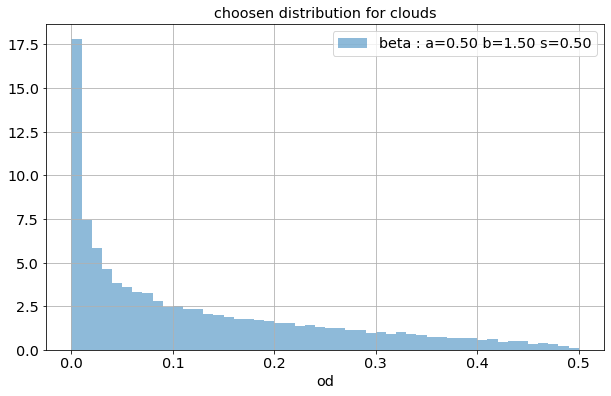

In [26]:
if FLAG_PLOT:
    x=np.linspace(simdata.min(),simdata.max(),100)
    if distrib_name=='beta':
        rv=beta(a=a,b=b,loc=loc, scale=scale)
    
    fig=plt.figure()
    ax=fig.add_subplot(111)
    label="beta : a={:2.2f} b={:2.2f} s={:2.2f}".format(a,b,scale)
    ax.hist(simdata,bins=50,density=True, histtype='stepfilled', alpha=0.5,label=label);
    #ax.plot(x,rv.pdf(x),"r-")
    ax.grid()
    ax.legend()
    ax.set_xlabel("od")
    ax.set_title("choosen distribution for clouds")

In [27]:
if 'AIRMASS' in config_section:
    distrib_name = config['AIRMASS']['distrib']
    a=float(config['AIRMASS']['a'])
    b=float(config['AIRMASS']['b'])
    loc=float(config['AIRMASS']['loc'])
    scale=float(config['AIRMASS']['scale'])

In [28]:
simdata=SimulateValues(NSIM,distrib_name,a,b,loc,scale)
AIRMASS = simdata

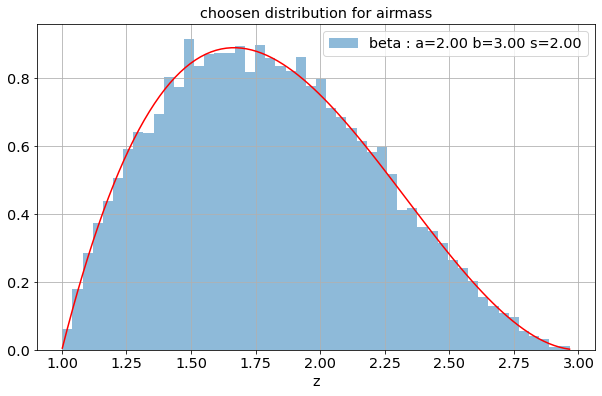

In [29]:
if FLAG_PLOT:
    x=np.linspace(simdata.min(),simdata.max(),100)
    if distrib_name=='beta':
        rv=beta(a=a,b=b,loc=loc, scale=scale)
    
    fig=plt.figure()
    ax=fig.add_subplot(111)
    labelb="beta : a={:2.2f} b={:2.2f} s={:2.2f}".format(a,b,scale)
    ax.hist(simdata,bins=50,density=True, histtype='stepfilled', alpha=0.5,label=labelb);
    ax.plot(x,rv.pdf(x),"r-")
    ax.grid()
    ax.legend()
    ax.set_xlabel("z")
    ax.set_title("choosen distribution for airmass")

In [30]:
data_indexes=np.arange(1,NSIM+1)

In [31]:
data_indexes=data_indexes[:,np.newaxis]
AIRMASS=AIRMASS[:,np.newaxis]
VAOD=VAOD[:,np.newaxis]
PWV=PWV[:,np.newaxis]
O3=O3[:,np.newaxis]
CLD=CLD[:,np.newaxis]

In [32]:
data_indexes

array([[    1],
       [    2],
       [    3],
       ...,
       [19998],
       [19999],
       [20000]])

In [33]:
data_out=np.concatenate([data_indexes,AIRMASS,VAOD,PWV,O3,CLD ],axis=1)

In [34]:
idx_out_num=0
idx_out_am=1
idx_out_vaod=2
idx_out_pwv=3
idx_out_o3=4
idx_out_cld=5
idx_out_res=6

In [35]:
hdr = fits.Header()
hdr['NBATMSIM']=NSIM
hdr['ID_NUM']=idx_out_num
hdr['ID_AM']=idx_out_am
hdr['ID_VAOD']=idx_out_vaod
hdr['ID_PWV']=idx_out_pwv
hdr['ID_O3']=idx_out_o3
hdr['ID_CLD']=idx_out_cld
hdr['ID_RES']=idx_out_res

output_fullfilename=os.path.join(output_dir,output_file)

hdu = fits.PrimaryHDU(data_out,header=hdr)
hdu.writeto(output_fullfilename,overwrite=True)

In [36]:
!ls -l $output_dir

total 1888
-rw-r--r--  1 sylvie  staff  964800 Dec 13 16:01 atmparam.fits


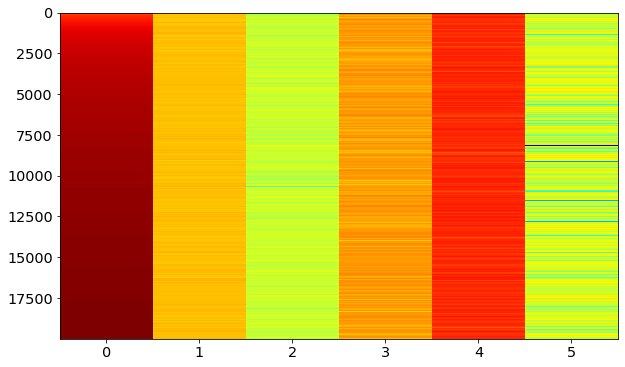

In [37]:
from matplotlib.colors import LogNorm
plt.imshow(data_out,aspect="auto",interpolation="nearest",norm=LogNorm(),cmap='jet')
#plt.imshow(data_out,aspect="auto",norm=LogNorm(),cmap='jet')